<h1>DELE CA1 Part B</h1>
<h2>Name         : Isaac low zu le</h2>
<h2>class        : DAAA/FT/2A/03</h2>
<h2>admin number : P2342348</h2>

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from deep_translator import GoogleTranslator
from matplotlib import pyplot as plt
import h5py
import pandas as pd
from deep_translator import GoogleTranslator
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
# Ensure necessary NLTK data packages are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Movie reviews.csv')
np.random.seed(1)


<h3>lets do some text-based analysis to see how the dataset looks like</h3>

In [3]:
df.info()
print("\n")
print("First 5 rows of the Dataframe:")
print(df.head(), end="\n\n\n")

print("Missing Values in Dataframe:")
print(df.isnull().sum(), end="\n\n\n")



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527 entries, 0 to 526
Data columns (total 4 columns):
 #   Column                                                                                 Non-Null Count  Dtype  
---  ------                                                                                 --------------  -----  
 0   Review                                                                                 527 non-null    object 
 1   Score                                                                                  525 non-null    float64
 2   Are there ways for you to generate more data? Spliting up sentences, would that help?  0 non-null      float64
 3   Language                                                                               527 non-null    object 
dtypes: float64(2), object(2)
memory usage: 16.6+ KB


First 5 rows of the Dataframe:
                                              Review  Score  \
0  Filem ini hebat! Aksi yang mendebarkan dan plo..

Since column "Are there ways for you to generate more data? Spliting up sentences, would that help?" does not contain any non- null values, i will be dropping it. since there are only two missing values in column Score, i will be dropping them too

In [4]:
df=df.drop("Are there ways for you to generate more data? Spliting up sentences, would that help?", axis=1)
df=df.dropna()



print("Missing Values in Dataframe:")
print(df.isnull().sum(), end="\n\n\n")

print("Different Languages present in Dataframe: ")
print(df["Language"].value_counts(),end="\n\n\n")

df.info()

Missing Values in Dataframe:
Review      0
Score       0
Language    0
dtype: int64


Different Languages present in Dataframe: 
Language
English    297
Malay      226
Chinese      1
Nippon       1
Name: count, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Index: 525 entries, 0 to 526
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Review    525 non-null    object 
 1   Score     525 non-null    float64
 2   Language  525 non-null    object 
dtypes: float64(1), object(2)
memory usage: 16.4+ KB


In [5]:
print(df[df["Language"] == 'Chinese'])

                    Review  Score Language
427  Hen tai fei chang hao  0.001  Chinese


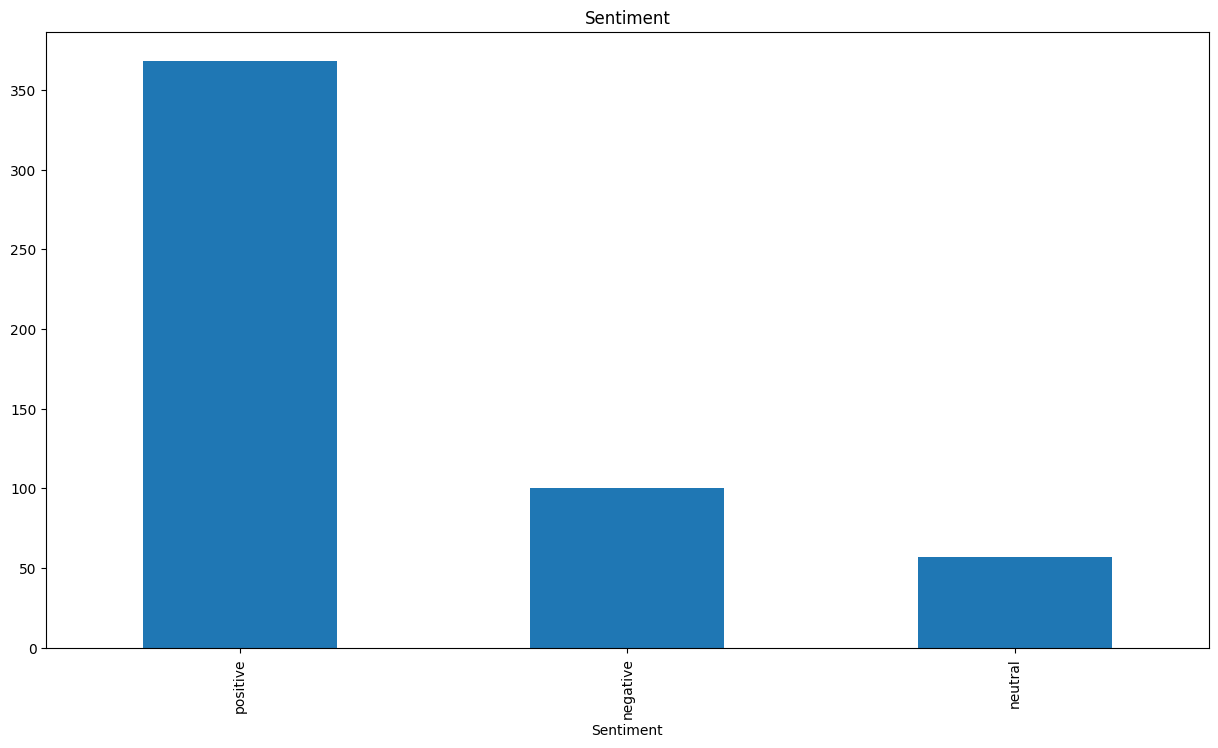

In [6]:


# Divide the 'Score' column into three classes
bins = [-1, 0.33, 0.66, 1]
labels = ['positive', 'neutral', 'negative']
df['Sentiment'] = pd.cut(df['Score'], bins=bins, labels=labels, include_lowest=True)


# Plot the histogram of the 'Sentiment' column
plt.figure(figsize=(15, 8))
df['Sentiment'].value_counts().plot(kind='bar', title='Sentiment')
plt.show()


In [7]:
print(df.isnull().sum(), end="\n\n\n")

Review       0
Score        0
Language     0
Sentiment    0
dtype: int64




Text(0.5, 1.0, 'Rows by language')

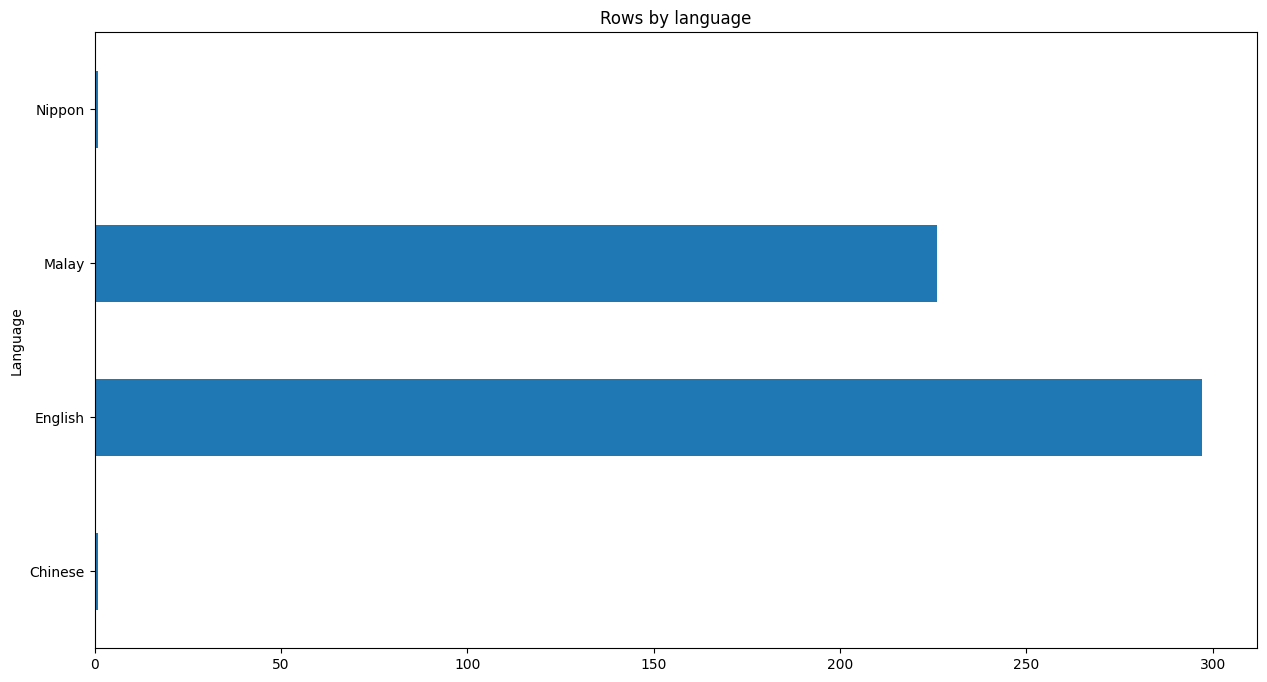

In [8]:


plt.figure(figsize=(15, 8))
df.groupby('Language').size().plot(kind='barh')
plt.title("Rows by language")

# plt.gca().spines[['top', 'right',]].set_visible(False)

Since there is only one chinese and one nippon entry, i will be dropping them

In [9]:

values_to_drop = ['Chinese', 'Nippon']

df = df[~df['Language'].isin(values_to_drop)]

<h3>now that we have analysed the dataset and cleaned up the data, we will proceed to data augmentation and preprocessing</h3>

In [10]:
df

,Review,Score,Language,Sentiment
0,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.1,Malay,positive
1,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.9,Malay,negative
2,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.5,Malay,neutral
3,"Sayang sekali, pelakon tidak memberikan persem...",0.8,Malay,negative
4,Jalan cerita yang kompleks dan penuh emosi. Su...,0.2,Malay,positive
...,...,...,...,...
522,Pening,0.7,Malay,negative
523,Berkesan,0.2,Malay,positive
524,Mengujakan,0.1,Malay,positive
525,Sederhana and teruk,0.6,Malay,neutral


In [11]:


def process_text(text, language):
    if pd.isna(text):
        return None

    if language.lower() != 'english':
        # Translate to English
        text = GoogleTranslator(source='auto', target='en').translate(text)

    tokens = word_tokenize(text)

    # Filter out punctuation marks
    tokens = [token for token in tokens if token.isalnum()]

    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Lemmatize and remove stop words
    tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.lower() not in stop_words]

    # Join the tokens back into a single string
    processed_text = ' '.join(tokens)

    return processed_text

# Assuming your DataFrame is named 'df'
df['Processed_Text'] = df.apply(lambda row: process_text(row['Review'], row['Language']), axis=1)








In [12]:
df

,Review,Score,Language,Sentiment,Processed_Text
0,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.1,Malay,positive,movie great thrilling action surprising plot
1,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.9,Malay,negative,movie great thrilling action surprising plot
2,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.5,Malay,neutral,movie great thrilling action surprising plot
3,"Sayang sekali, pelakon tidak memberikan persem...",0.8,Malay,negative,bad actor give best performance satisfied
4,Jalan cerita yang kompleks dan penuh emosi. Su...,0.2,Malay,positive,complex emotional storyline really entertaining
...,...,...,...,...,...
522,Pening,0.7,Malay,negative,dizziness
523,Berkesan,0.2,Malay,positive,effective
524,Mengujakan,0.1,Malay,positive,exciting
525,Sederhana and teruk,0.6,Malay,neutral,simple bad


In [13]:


# Create a Tokenizer instance
tokenizer = Tokenizer()

# Fit the tokenizer on the processed text
tokenizer.fit_on_texts(df['Processed_Text'])

# Convert the processed text to sequences of integers
sequences = tokenizer.texts_to_sequences(df['Processed_Text'])

word_index = tokenizer.word_index

vocab_size = len(word_index) + 1

# Pad the sequences to a fixed length
max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Create a new DataFrame with the padded sequences
padded_df = pd.DataFrame({'Padded_Sequences': padded_sequences.tolist()})

df = pd.concat([df, padded_df], axis=1)

In [14]:
df

,Review,Score,Language,Sentiment,Processed_Text,Padded_Sequences
0,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.1,Malay,positive,movie great thrilling action surprising plot,"[4, 27, 32, 3, 104, 2, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.9,Malay,negative,movie great thrilling action surprising plot,"[4, 27, 32, 3, 104, 2, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.5,Malay,neutral,movie great thrilling action surprising plot,"[4, 27, 32, 3, 104, 2, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,"Sayang sekali, pelakon tidak memberikan persem...",0.8,Malay,negative,bad actor give best performance satisfied,"[150, 16, 131, 447, 14, 216, 0, 0, 0, 0, 0, 0,..."
4,Jalan cerita yang kompleks dan penuh emosi. Su...,0.2,Malay,positive,complex emotional storyline really entertaining,"[39, 10, 30, 83, 95, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
...,...,...,...,...,...,...
526,Sempurna,0.1,Malay,positive,perfect,NaN
426,NaN,NaN,NaN,NaN,NaN,"[124, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
427,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
484,NaN,NaN,NaN,NaN,NaN,"[445, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


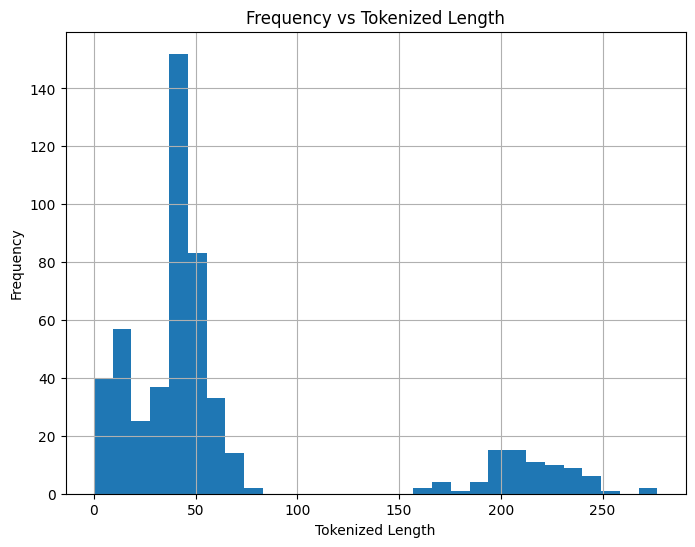

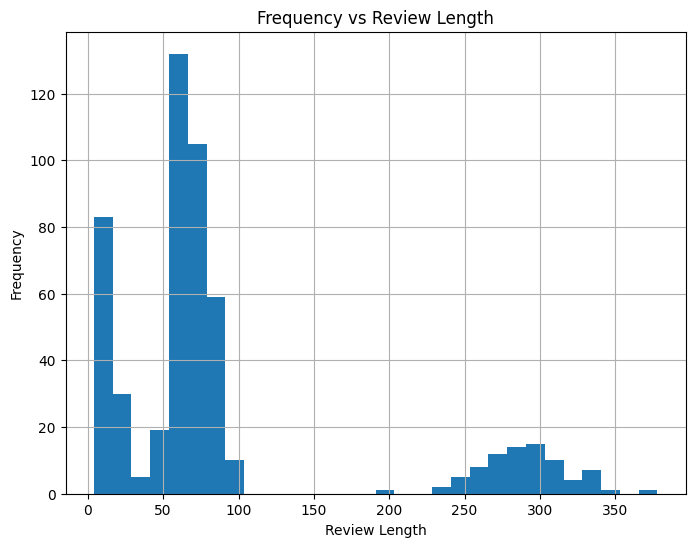

In [15]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df' and has the specified columns

# Plot frequency vs tokenized length
tokenized_lengths = df['Processed_Text'].str.len()
plt.figure(figsize=(8, 6))
tokenized_lengths.hist(bins=30)
plt.xlabel('Tokenized Length')
plt.ylabel('Frequency')
plt.title('Frequency vs Tokenized Length')
plt.show()

# Plot frequency vs review length
review_lengths = df['Review'].str.len()
plt.figure(figsize=(8, 6))
review_lengths.hist(bins=30)
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Frequency vs Review Length')
plt.show()


here we can see how through lemmitization, we have managed to cut down the number of words by alot

In [16]:
df=df.dropna()
df

,Review,Score,Language,Sentiment,Processed_Text,Padded_Sequences
0,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.1,Malay,positive,movie great thrilling action surprising plot,"[4, 27, 32, 3, 104, 2, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.9,Malay,negative,movie great thrilling action surprising plot,"[4, 27, 32, 3, 104, 2, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.5,Malay,neutral,movie great thrilling action surprising plot,"[4, 27, 32, 3, 104, 2, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,"Sayang sekali, pelakon tidak memberikan persem...",0.8,Malay,negative,bad actor give best performance satisfied,"[150, 16, 131, 447, 14, 216, 0, 0, 0, 0, 0, 0,..."
4,Jalan cerita yang kompleks dan penuh emosi. Su...,0.2,Malay,positive,complex emotional storyline really entertaining,"[39, 10, 30, 83, 95, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
...,...,...,...,...,...,...
518,Kembara epik,0.1,Malay,positive,epic adventure,"[667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
519,Menakjubkan,0.1,Malay,positive,amazing,"[668, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
520,Kacau bilau,0.8,Malay,negative,chaos,"[277, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
521,Menawan hati,0.2,Malay,positive,captivating,"[669, 150, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [17]:
final_df = df[['Sentiment', 'Padded_Sequences']]


In [18]:
final_df = pd.get_dummies(final_df, columns=['Sentiment'])


In [19]:
final_df

,Padded_Sequences,Sentiment_positive,Sentiment_neutral,Sentiment_negative
0,"[4, 27, 32, 3, 104, 2, 0, 0, 0, 0, 0, 0, 0, 0,...",True,False,False
1,"[4, 27, 32, 3, 104, 2, 0, 0, 0, 0, 0, 0, 0, 0,...",False,False,True
2,"[4, 27, 32, 3, 104, 2, 0, 0, 0, 0, 0, 0, 0, 0,...",False,True,False
3,"[150, 16, 131, 447, 14, 216, 0, 0, 0, 0, 0, 0,...",False,False,True
4,"[39, 10, 30, 83, 95, 0, 0, 0, 0, 0, 0, 0, 0, 0...",True,False,False
...,...,...,...,...
518,"[667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",True,False,False
519,"[668, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",True,False,False
520,"[277, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",False,False,True
521,"[669, 150, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,False,False


In [20]:
final_df[['Sentiment_positive', 'Sentiment_neutral', 'Sentiment_negative']] = final_df[['Sentiment_positive', 'Sentiment_neutral', 'Sentiment_negative']].astype(int)

In [21]:
final_df

,Padded_Sequences,Sentiment_positive,Sentiment_neutral,Sentiment_negative
0,"[4, 27, 32, 3, 104, 2, 0, 0, 0, 0, 0, 0, 0, 0,...",1,0,0
1,"[4, 27, 32, 3, 104, 2, 0, 0, 0, 0, 0, 0, 0, 0,...",0,0,1
2,"[4, 27, 32, 3, 104, 2, 0, 0, 0, 0, 0, 0, 0, 0,...",0,1,0
3,"[150, 16, 131, 447, 14, 216, 0, 0, 0, 0, 0, 0,...",0,0,1
4,"[39, 10, 30, 83, 95, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1,0,0
...,...,...,...,...
518,"[667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1,0,0
519,"[668, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1,0,0
520,"[277, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0,0,1
521,"[669, 150, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,0,0


In [22]:
X = final_df['Padded_Sequences'].tolist()
X = np.array(X)
y = final_df[['Sentiment_positive', 'Sentiment_neutral', 'Sentiment_negative']].values
y = np.eye(3)[np.argmax(y, axis=1)]

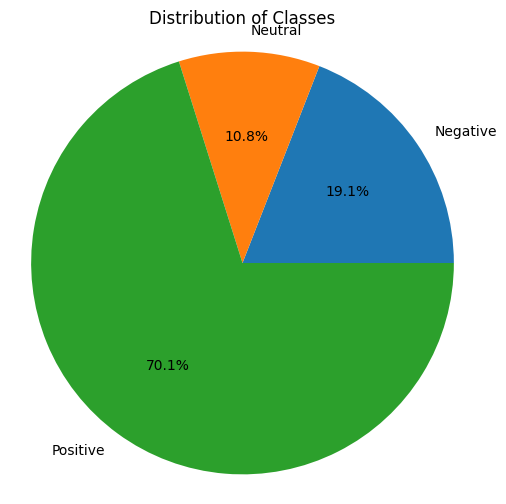

In [23]:
# Count the occurrences of each class
unique_labels, counts = np.unique(np.array(y), axis=0, return_counts=True)

# Create a dictionary to map the labels
label_map = {
    '[1. 0. 0.]': 'Positive',
    '[0. 1. 0.]': 'Neutral',
    '[0. 0. 1.]': 'Negative'
}

# Create the pie chart
plt.figure(figsize=(6, 6))
labels = [label_map.get(str(label), str(label)) for label in unique_labels]
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Distribution of Classes')
plt.show()

here we can see that the dataset is super unbalanced with overwhelmingly positive data. This is not very good as it may cause the model to becoemme biased. therefore, i will try and equalize the classes in my training set

In [24]:
print(X.shape)
print(y.shape)

(519, 34)
(519, 3)


In [25]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Assuming top_words is the size of your vocabulary
top_words = vocab_size
max_words = 34  # Maximum sequence length


def create_model(vocab_size, max_words):
    model = Sequential()
    model.add(Embedding(vocab_size, 32, input_length=max_words))
    model.add(Flatten())
    model.add(Dense(250, activation='relu'))
    model.add(Dense(3, activation='softmax'))  # Output layer with 3 classes and softmax activation
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model




In [27]:
def plot_accuracy_loss(history):
    # Plot the accuracy
    plt.figure(figsize=(8, 6))
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot the loss
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()


here, we will try training our model once to establish a baseline to work off of

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.5077 - loss: 1.0047 - val_accuracy: 0.7981 - val_loss: 0.6939
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6400 - loss: 0.8920 - val_accuracy: 0.7981 - val_loss: 0.7377
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6832 - loss: 0.7853 - val_accuracy: 0.7981 - val_loss: 0.6299
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6642 - loss: 0.7607 - val_accuracy: 0.8173 - val_loss: 0.6105
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7261 - loss: 0.6129 - val_accuracy: 0.8462 - val_loss: 0.4909
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8431 - loss: 0.4704 - val_accuracy: 0.8750 - val_loss: 0.4394
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8645 - loss: 0.3708 - val_accuracy: 0.8750 - val_loss: 0.3561
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8909 - loss: 0.2654 - val_accuracy: 0.8942 - val_loss: 0.3217
E

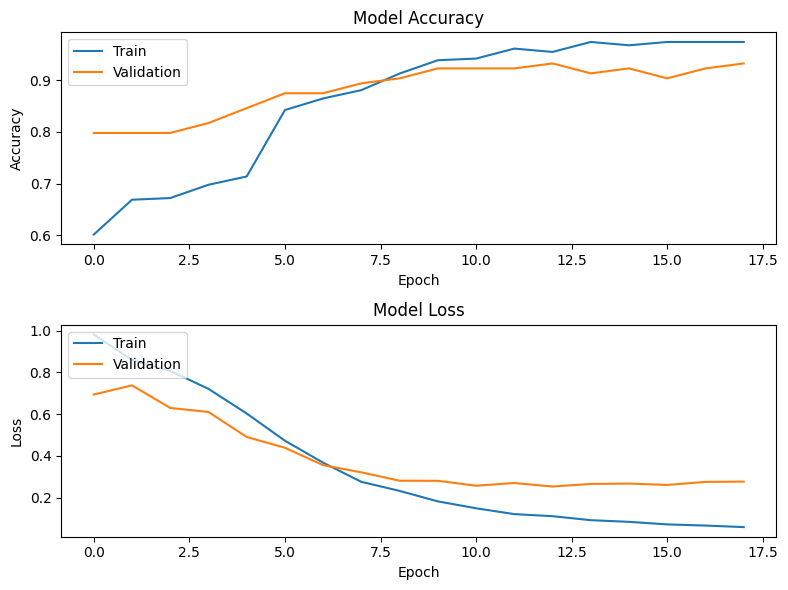

In [29]:


np.random.seed(42)



# implement early stopping
earlyStopping = EarlyStopping(monitor="val_loss", patience=5)

model = create_model(vocab_size, max_words)

# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, callbacks=[earlyStopping])


plot_accuracy_loss(history)

here we can seeee that our preliminary model achieved<br>
val_loss: 0.2527 - val_accuracy: 0.9231 <br>
lets see if oversampling improves the data

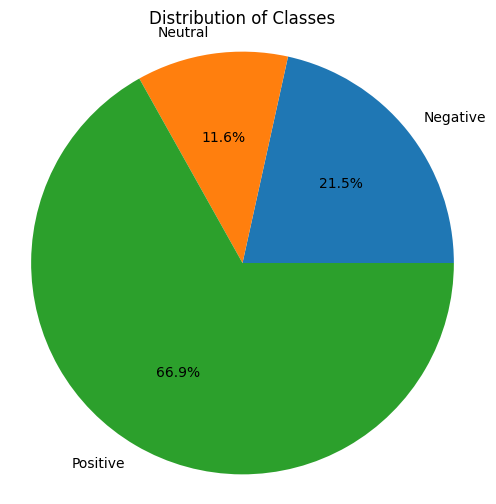

In [30]:
# Count the occurrences of each class
unique_labels, counts = np.unique(np.array(y_train), axis=0, return_counts=True)

# Create a dictionary to map the labels
label_map = {
    '[1. 0. 0.]': 'Positive',
    '[0. 1. 0.]': 'Neutral',
    '[0. 0. 1.]': 'Negative'
}

# Create the pie chart
plt.figure(figsize=(6, 6))
labels = [label_map.get(str(label), str(label)) for label in unique_labels]
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Distribution of Classes')
plt.show()

In [31]:
import numpy as np
from sklearn.utils import resample
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Find the indices of the negative, neutral, and positive classes in the training labels
negative_indices = np.where(y_train[:, 0] == 1)[0]
neutral_indices = np.where(y_train[:, 1] == 1)[0]
positive_indices = np.where(y_train[:, 2] == 1)[0]

# Calculate the target size for each class as the maximum of the class lengths
target_size = max(len(negative_indices), len(neutral_indices), len(positive_indices))

# Upsample the negative and neutral classes to the target size using resample()
negative_upsampled, negative_labels = resample(X_train[negative_indices], y_train[negative_indices], replace=True, n_samples=target_size, random_state=42)
neutral_upsampled, neutral_labels = resample(X_train[neutral_indices], y_train[neutral_indices], replace=True, n_samples=target_size, random_state=42)
positive_upsampled, positive_labels = resample(X_train[positive_indices], y_train[positive_indices], replace=True, n_samples=target_size, random_state=42)

# Find the maximum length among the original and upsampled sequences
max_length = max(X_train.shape[1], negative_upsampled.shape[1], neutral_upsampled.shape[1], positive_upsampled.shape[1])

# Pad the original and upsampled sequences to the max_length using post padding
X_train_padded = pad_sequences(X_train, maxlen=max_length, padding='post')
negative_padded = pad_sequences(negative_upsampled, maxlen=max_length, padding='post')
neutral_padded = pad_sequences(neutral_upsampled, maxlen=max_length, padding='post')
positive_padded = pad_sequences(positive_upsampled, maxlen=max_length, padding='post')

# Concatenate the original and upsampled data to create the expanded datasets
X_expanded = np.concatenate([X_train_padded, negative_padded, neutral_padded, positive_padded], axis=0)
y_expanded = np.concatenate([y_train, negative_labels, neutral_labels, positive_labels], axis=0)

# Shuffle the expanded datasets using random permutation
shuffle_indices = np.random.permutation(len(X_expanded))
X_train = X_expanded[shuffle_indices]
y_train = y_expanded[shuffle_indices]

X_train_oversampled_backup=X_train
y_train_oversampled_backup=y_train

# X_train=X_train_oversampled_backup
# y_train=y_train_oversampled_backup

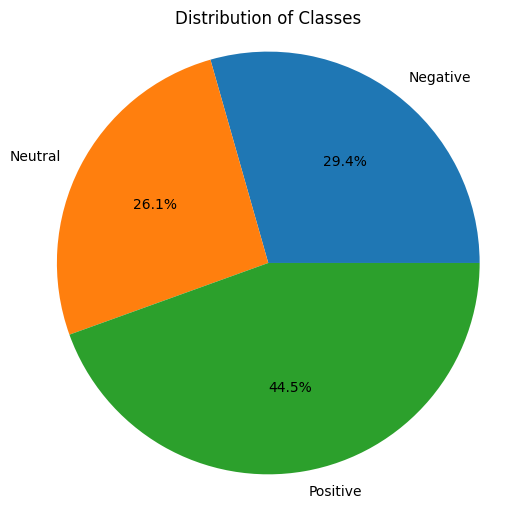

In [32]:
# Count the occurrences of each class
unique_labels, counts = np.unique(np.array(y_train), axis=0, return_counts=True)

# Create a dictionary to map the labels
label_map = {
    '[1. 0. 0.]': 'Positive',
    '[0. 1. 0.]': 'Neutral',
    '[0. 0. 1.]': 'Negative'
}

# Create the pie chart
plt.figure(figsize=(6, 6))
labels = [label_map.get(str(label), str(label)) for label in unique_labels]
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Distribution of Classes')
plt.show()

In [33]:
print(y_train.shape)

(935, 3)


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4933 - loss: 1.0481 - val_accuracy: 0.8365 - val_loss: 0.6640
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7841 - loss: 0.6704 - val_accuracy: 0.9135 - val_loss: 0.3545
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9272 - loss: 0.2428 - val_accuracy: 0.9135 - val_loss: 0.2830
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9768 - loss: 0.1041 - val_accuracy: 0.9231 - val_loss: 0.2646
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9866 - loss: 0.0675 - val_accuracy: 0.9231 - val_loss: 0.2856
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9829 - loss: 0.0526 - val_accuracy: 0.9135 - val_loss: 0.2647
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9784 - loss: 0.0430 - val_accuracy: 0.9135 - val_loss: 0.2870
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9877 - loss: 0.0361 - val_accuracy: 0.9231 - val_loss

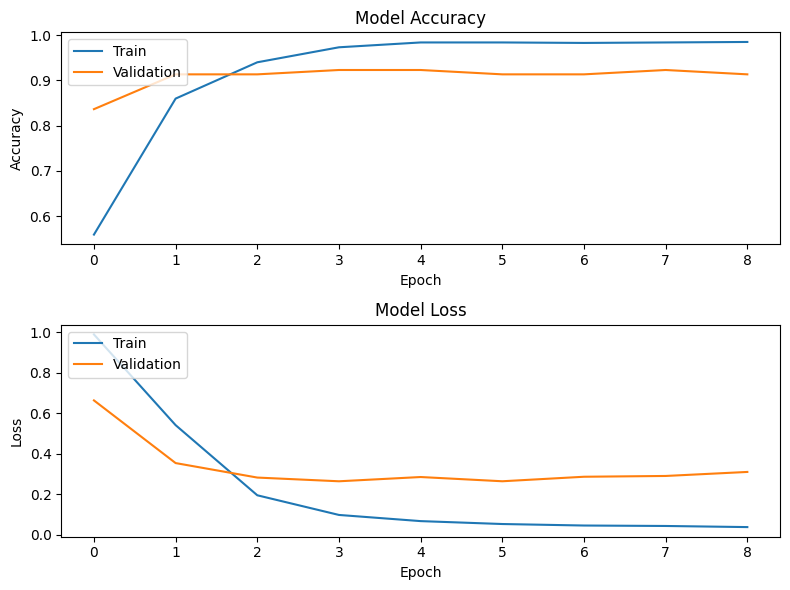

In [35]:
np.random.seed(42)



# implement early stopping
earlyStopping = EarlyStopping(monitor="val_loss", patience=5)

model = create_model(vocab_size, max_words)

# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, callbacks=[earlyStopping])


plot_accuracy_loss(history)

without oversampling:<br>
val_accuracy: 0.9327 - val_loss: 0.2775 <br>
with:<br>
val_accuracy: 0.9135 - val_loss: 0.3108<br>
oversampling does not have a really large positive impact


now i will try adding layers to see if it improves accuracy

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, GRU, LSTM, TimeDistributed

def create_model(vocab_size, max_words):
    model = Sequential()
    model.add(Embedding(vocab_size, 32, input_length=max_words))

    # Add a GRU layer
    model.add(GRU(64, return_sequences=True))
    model.add(GRU(32))


    model.add(Dense(250, activation='relu'))
    model.add(Dense(3, activation='softmax'))  # Output layer with 3 classes and softmax activation
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [50]:
# X_train=X_train_oversampled_backup
# y_train=y_train_oversampled_backup
X = final_df['Padded_Sequences'].tolist()
X = np.array(X)
y = final_df[['Sentiment_positive', 'Sentiment_neutral', 'Sentiment_negative']].values
y = np.eye(3)[np.argmax(y, axis=1)]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.5347 - loss: 1.0679 - val_accuracy: 0.7981 - val_loss: 0.8090
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6731 - loss: 0.8819 - val_accuracy: 0.7981 - val_loss: 0.6580
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6723 - loss: 0.8427 - val_accuracy: 0.7981 - val_loss: 0.7285
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6521 - loss: 0.8834 - val_accuracy: 0.7981 - val_loss: 0.6866
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6690 - loss: 0.8564 - val_accuracy: 0.7981 - val_loss: 0.6583
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6485 - loss: 0.8833 - val_accuracy: 0.7981 - val_loss: 0.7026
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6777 - loss: 0.8338 - val_accuracy: 0.7981 - val_loss: 0.6756


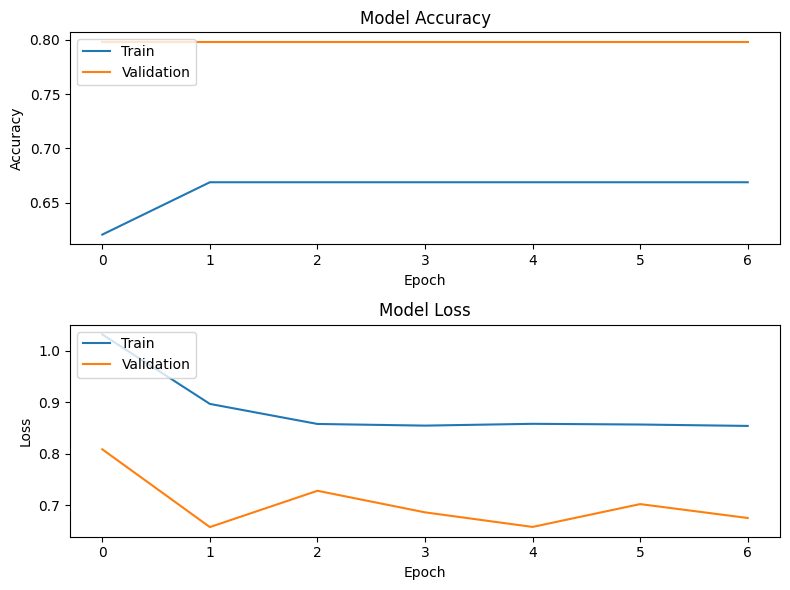

In [38]:
np.random.seed(42)



# implement early stopping
earlyStopping = EarlyStopping(monitor="val_loss", patience=5)

model = create_model(vocab_size, max_words)

# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, callbacks=[earlyStopping])


plot_accuracy_loss(history)

this new model has a very poor performance, mmaybe we can help it with hyperparameter tuning
without oversampling:<br>
val_accuracy: 0.9327 - val_loss: 0.2775 <br>
with:<br>
val_accuracy: 0.9135 - val_loss: 0.3108<br>
GRU:<br>
val_accuracy: 0.7981 - val_loss: 0.6756<br>

In [39]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(311, 34)
(311, 3)
(104, 34)
(104, 3)


<h1>Hyperparameter tuning</h1>
now i will be moving on to hyperparameter tuning to improve my model's characteristics

In [102]:
# X_train=X_train_oversampled_backup
# y_train=y_train_oversampled_backup
X = final_df['Padded_Sequences'].tolist()
X = np.array(X)
y = final_df[['Sentiment_positive', 'Sentiment_neutral', 'Sentiment_negative']].values
y = np.eye(3)[np.argmax(y, axis=1)]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [76]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

def create_model(neuron=32):
    model = Sequential()
    model.add(Embedding(671, 32, input_length=34))

    # Add a GRU layer
    model.add(GRU(neuron, return_sequences=True))
    model.add(GRU(32))


    model.add(Dense(250, activation='relu'))
    model.add(Dense(3, activation='softmax'))  # Output layer with 3 classes and softmax activation
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model



param_grid = {
    'neuron':[16,32,64,128,256]
}

random_search = RandomizedSearchCV(
    estimator=KerasClassifier(model=create_model, epochs=10, batch_size=32, verbose=0, neuron=16),
    param_distributions=param_grid,
    n_iter=5,
    cv=3,
    verbose=2
)

random_search.fit(X_train, y_train, validation_data=(X_val, y_val))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ..........................................neuron=16; total time=   0.0s
[CV] END ..........................................neuron=16; total time=   0.0s
[CV] END ..........................................neuron=16; total time=   0.0s
[CV] END ..........................................neuron=32; total time=   0.0s
[CV] END ..........................................neuron=32; total time=   0.0s
[CV] END ..........................................neuron=32; total time=   0.0s
[CV] END ..........................................neuron=64; total time=   0.0s
[CV] END ..........................................neuron=64; total time=   0.0s
[CV] END ..........................................neuron=64; total time=   0.0s
[CV] END .........................................neuron=128; total time=   0.0s
[CV] END .........................................neuron=128; total time=   0.0s
[CV] END ........................................

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/p

[CV] END .........................................neuron=256; total time=   0.0s


ValueError: 
All the 15 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_314' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_315' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_316' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_317' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_318' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_319' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_320' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_321' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_322' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_323' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_324' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_325' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_326' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_327' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_328' has no defined outputs yet.


in the end, the best model is the model we started with. lets see its accuraccy against the test set

In [103]:
def create_model(vocab_size, max_words):
    model = Sequential()
    model.add(Embedding(vocab_size, 32, input_length=max_words))
    model.add(Flatten())
    model.add(Dense(250, activation='relu'))
    model.add(Dense(3, activation='softmax'))  # Output layer with 3 classes and softmax activation
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6509 - loss: 0.9044 - val_accuracy: 0.7019 - val_loss: 0.7701
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6914 - loss: 0.7262 - val_accuracy: 0.7596 - val_loss: 0.6208
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8313 - loss: 0.4526 - val_accuracy: 0.8173 - val_loss: 0.4734
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9083 - loss: 0.2903 - val_accuracy: 0.8558 - val_loss: 0.4381
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9387 - loss: 0.1636 - val_accuracy: 0.8462 - val_loss: 0.3948
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9723 - loss: 0.0967 - val_accuracy: 0.8173 - val_loss: 0.3992
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9647 - loss: 0.0950 - val_accuracy: 0.8365 - val_loss: 0.4223
Epoch 8/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9670 - loss: 0.0859 - val_accuracy: 0.8365 - val_loss

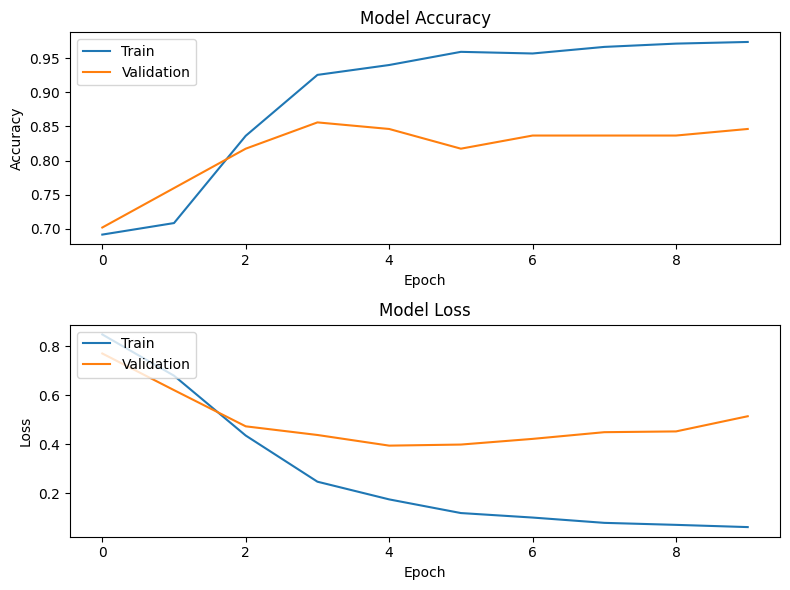

In [106]:
np.random.seed(42)



# implement early stopping
earlyStopping = EarlyStopping(monitor="val_loss", patience=5)

model = create_model(vocab_size, max_words)

# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=10, callbacks=[earlyStopping])


plot_accuracy_loss(history)

In [113]:
model.save_weights('model_rnn.weights.h5')

In [87]:
model.summary()

Model: "sequential_331"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_331 (Embedding)            │ (None, 34, 32)              │          21,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_33 (Flatten)                 │ (None, 1088)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_662 (Dense)                    │ (None, 250)                 │         272,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_663 (Dense)                    │ (None, 3)                   │             753 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 883,427 (3.37 MB)

 Trainable params: 294,475 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 588,952 (2.25 MB)

In [110]:
pip install --upgrade scikit-learn


In [114]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have a trained model and test data
y_true = y_test  # True labels of the test data
y_pred = model.predict(X_test)  # Predicted labels by the model

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

final results:val_accuracy: 0.8462 - val_loss: 0.5145